In [1]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input


In [2]:
# Load and preprocess the data
def load_and_preprocess_data(data):
    images = []
    labels = []
    for label, image_paths in data.items():
        for path in image_paths:
            img = cv2.imread(str(path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
            img = cv2.resize(img, (224, 224))  # Resize image to VGG19 input size
            images.append(img)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [3]:
# Load data
path = pathlib.Path(r"kvasir-dataset")

In [4]:
dyed_ifted_polyps = list(path.glob('dyed-lifted-polyps/*'))
dyed_resection_margins = list(path.glob('dyed-resection-margins/*'))
esophagitis = list(path.glob('esophagitis/*'))
normal_cecum = list(path.glob('normal-cecum/*'))
normal_pylorus = list(path.glob('normal-pylorus/*'))
normal_z_line = list(path.glob('normal-z-line/*'))
polyps = list(path.glob('polyps/*'))
ulcerative_colitis = list(path.glob('ulcerative-colitis/*'))

In [5]:
data = {
    'dyed-lifted-polyps' : dyed_ifted_polyps ,
    'dyed-resection-margins' : dyed_resection_margins,
    'esophagitis' : esophagitis,
    'normal-cecum' : normal_cecum,
    'normal-pylorus' : normal_pylorus,
    'normal-z-line' : normal_z_line,
    'polyps' : polyps,
    'ulcerative-colitis' : ulcerative_colitis
}

polys_labels = {
    0:'dyed-lifted-polyps',
    1:'dyed-resection-margins',
    2:'esophagitis',
    3:'normal-cecum',
    4:'normal-pylorus',
    5:'normal-z-line',
    6:'polyps',
    7:'ulcerative-colitis'
}

In [6]:
images, labels = load_and_preprocess_data(data)

In [7]:
print(len(images))

4000


In [8]:
# Split the data into training, validation, and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [9]:
train_data_19 = vgg19_preprocess_input(train_data)
val_data_19 = vgg19_preprocess_input(val_data)
test_data_19 = vgg19_preprocess_input(test_data)

In [10]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [11]:
from tensorflow.keras.applications import VGG19

In [12]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create the model
model_vgg19 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Adjust the output units based on the number of classes
])

In [13]:
# Compile the model
model_vgg19.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model
history_vgg19 = model_vgg19.fit(train_data_19, train_labels_encoded, epochs=10, batch_size=32, validation_data=(val_data, val_labels_encoded))

# Evaluate the model
test_loss, test_acc = model_vgg19.evaluate(test_data_19, test_labels_encoded)
print(f'Test Accuracy: {test_acc}')

Epoch 1/10
80/80 [==============================] - 342s 4s/step - loss: 5.7400 - accuracy: 0.6434 - val_loss: 2.2207 - val_accuracy: 0.4938
Epoch 2/10
80/80 [==============================] - 333s 4s/step - loss: 0.8440 - accuracy: 0.7230 - val_loss: 1.7304 - val_accuracy: 0.5641
Epoch 3/10
80/80 [==============================] - 337s 4s/step - loss: 0.6521 - accuracy: 0.7801 - val_loss: 2.3770 - val_accuracy: 0.5156
Epoch 4/10
80/80 [==============================] - 340s 4s/step - loss: 0.5896 - accuracy: 0.8012 - val_loss: 4.4045 - val_accuracy: 0.4828
Epoch 5/10
80/80 [==============================] - 340s 4s/step - loss: 0.5202 - accuracy: 0.8121 - val_loss: 2.3678 - val_accuracy: 0.5328
Epoch 6/10
80/80 [==============================] - 339s 4s/step - loss: 0.4904 - accuracy: 0.8406 - val_loss: 4.6183 - val_accuracy: 0.4984
Epoch 7/10
80/80 [==============================] - 340s 4s/step - loss: 0.4289 - accuracy: 0.8516 - val_loss: 2.5350 - val_accuracy: 0.5297
Epoch 8/10
80

In [17]:
# Print model summary
model_vgg19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 26449224 (100.90 MB)
Trainable params: 6424840 (24.51 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [19]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import preprocess_input

# Define the number of folds for cross-validation
num_folds = 5

# Define your VGG19 base model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Define the number of classes
num_classes = 8  # Update with the number of classes in your dataset

# Define a function to create the VGG16 model
def create_vgg19_model():
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Perform cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(train_data, train_labels_encoded)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    # Create VGG16 model
    model = create_vgg19_model()
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Preprocess training and validation data
    train_data_preprocessed = preprocess_input(train_data[train_index])
    val_data_preprocessed = preprocess_input(train_data[val_index])
    
    # Train the model
    model.fit(train_data_preprocessed, train_labels_encoded[train_index], epochs=5, batch_size=50, verbose=1,
              validation_data=(val_data_preprocessed, train_labels_encoded[val_index]))
    
    # Evaluate the model on validation data
    val_loss, val_acc = model.evaluate(val_data_preprocessed, train_labels_encoded[val_index], verbose=0)
    print(f"Validation Accuracy: {val_acc}")
    cv_scores.append(val_acc)

# Calculate and print the mean cross-validation score
mean_cv_score = np.mean(cv_scores)
print(f"Mean Cross-Validation Accuracy: {mean_cv_score}")

Fold 1/5
Epoch 1/5
41/41 [==============================] - 283s 7s/step - loss: 11.4285 - accuracy: 0.6011 - val_loss: 0.9810 - val_accuracy: 0.8125
Epoch 2/5
41/41 [==============================] - 280s 7s/step - loss: 0.9721 - accuracy: 0.7310 - val_loss: 0.5940 - val_accuracy: 0.7676
Epoch 3/5
41/41 [==============================] - 274s 7s/step - loss: 0.6631 - accuracy: 0.7734 - val_loss: 0.6002 - val_accuracy: 0.8086
Epoch 4/5
41/41 [==============================] - 270s 7s/step - loss: 0.5524 - accuracy: 0.7998 - val_loss: 0.5586 - val_accuracy: 0.8008
Epoch 5/5
41/41 [==============================] - 270s 7s/step - loss: 0.4686 - accuracy: 0.8418 - val_loss: 0.6225 - val_accuracy: 0.8105
Validation Accuracy: 0.810546875
Fold 2/5
Epoch 1/5
41/41 [==============================] - 272s 7s/step - loss: 8.4920 - accuracy: 0.5859 - val_loss: 0.8143 - val_accuracy: 0.7559
Epoch 2/5
41/41 [==============================] - 272s 7s/step - loss: 0.9429 - accuracy: 0.6885 - val_loss

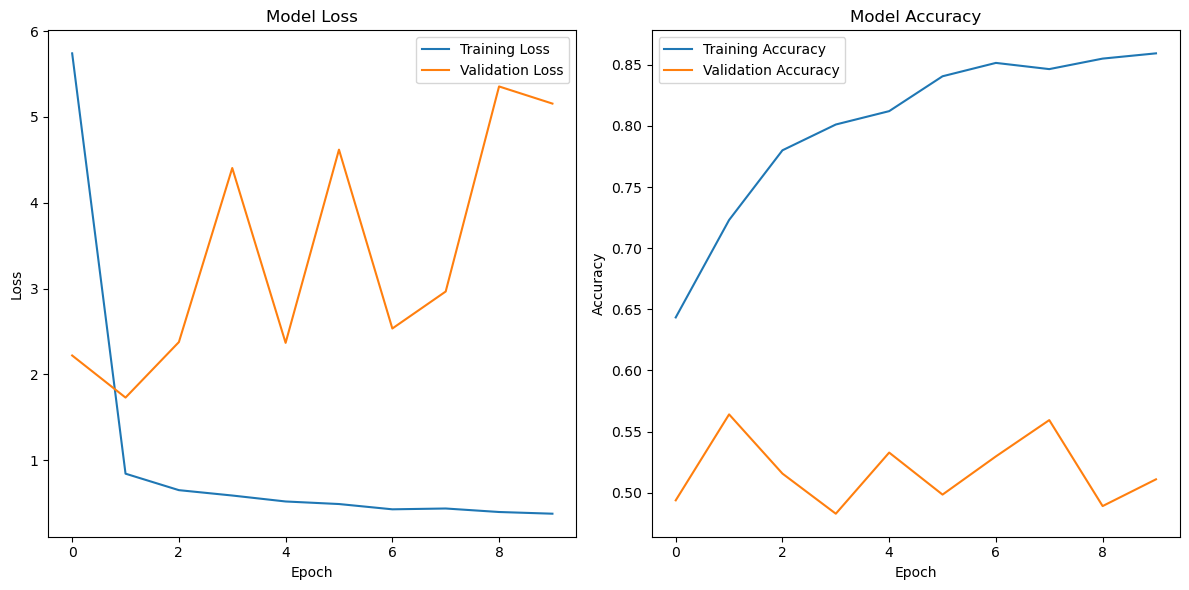

In [20]:
# Plot learning curves
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history_vgg19.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

25/25 [==============================] - 90s 3s/step


<Figure size 800x800 with 0 Axes>

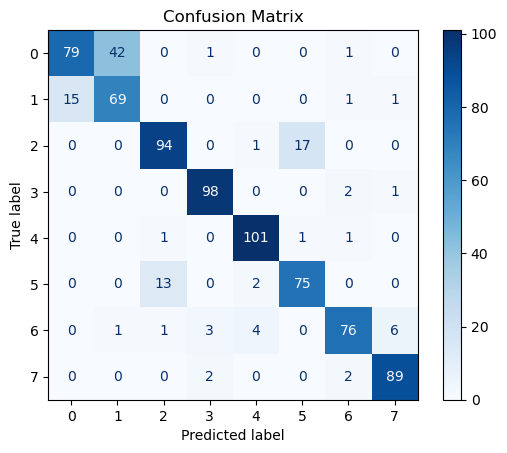

In [21]:
# Generate confusion matrix
predictions = model_vgg19.predict(test_data_19)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels_encoded, predicted_labels)
classes = [str(i) for i in range(8)]  # Assuming you have 8 classes

# Plot confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score

# Compute Precision and Recall for multiclass classification
precision = precision_score(test_labels_encoded, predictions.argmax(axis=1), average='macro')
recall = recall_score(test_labels_encoded, predictions.argmax(axis=1), average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.8545018994727036
Recall: 0.856353251264013


ROC AUC Score: 0.9865346411069655


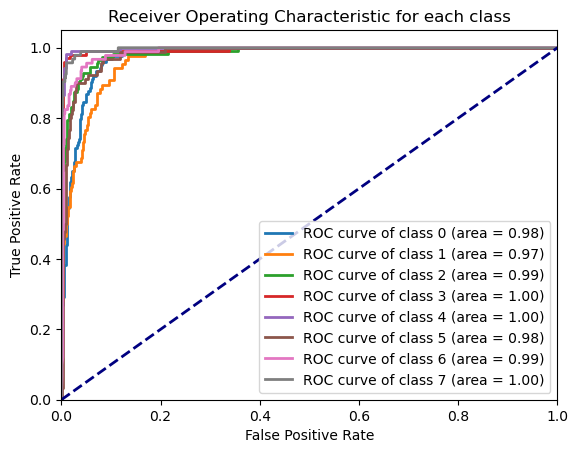

In [23]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize the true labels
y_test_binarized = label_binarize(test_labels_encoded, classes=np.unique(test_labels_encoded))

# Calculate AUC for each class
roc_auc = roc_auc_score(y_test_binarized, predictions, multi_class='ovr')

print(f'ROC AUC Score: {roc_auc}')

# Plot ROC curve for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()